In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib

# Notebook 1 â€“ Modelo No ParamÃ©trico (Ãrbol de DecisiÃ³n)

Este notebook explora el dataset `WEC_Perth_100.csv` para entender cÃ³mo la disposiciÃ³n geomÃ©trica de los aerogeneradores impacta la producciÃ³n total de potencia mediante un Ã¡rbol de decisiÃ³n regularizado.

**Objetivos**
- Extraer mÃ©tricas fÃ­sicas y geomÃ©tricas relevantes para caracterizar cada layout.
- Ajustar un Decision Tree con validaciÃ³n cruzada para obtener predicciones estables.
- Documentar interpretabilidad y guardar el pipeline final para futuras comparaciones.

**Estructura del anÃ¡lisis**
1. Carga y exploraciÃ³n inicial del dataset.
2. IngenierÃ­a geomÃ©trica de features que describen el parque.
3. DivisiÃ³n train/test y validaciÃ³n interna.
4. BÃºsqueda de hiperparÃ¡metros para controlar la complejidad.
5. EvaluaciÃ³n numÃ©rica y visual.
6. InterpretaciÃ³n de importancias.
7. Guardado del pipeline final.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from joblib import dump

# Modelos y métricas
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist

# Configuración
RANDOM_STATE = 42
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Entorno configurado.")


✅ Entorno configurado.


## 1. Carga y exploraciÃ³n inicial

- Carga del CSV y eliminaciÃ³n de duplicados para asegurar muestras Ãºnicas.
- AnÃ¡lisis estadÃ­stico de `Total_Power` y su vÃ­nculo con `qW`.
- VisualizaciÃ³n de la distribuciÃ³n energÃ©tica y su dependencia con `qW`.

Filas originales: 7,277
Filas únicas tras eliminar duplicados: 2,737
        Total_Power           qW
count  2.737000e+03  2737.000000
mean   6.959157e+06     0.721995
std    1.998767e+05     0.020921
min    6.099480e+06     0.630000
25%    6.806309e+06     0.710000
50%    6.941249e+06     0.720000
75%    7.129514e+06     0.740000
max    7.364528e+06     0.760000


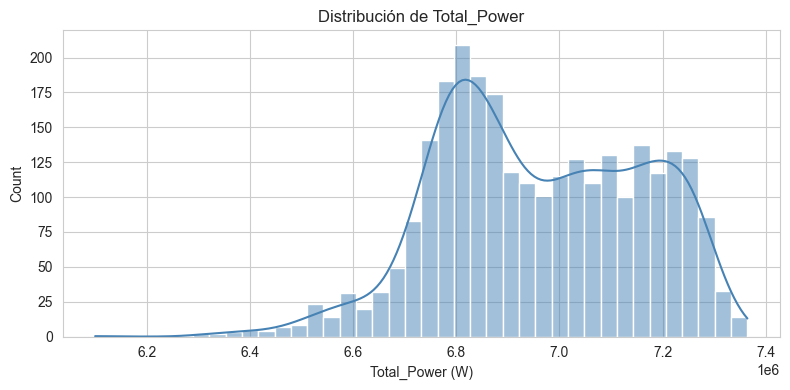

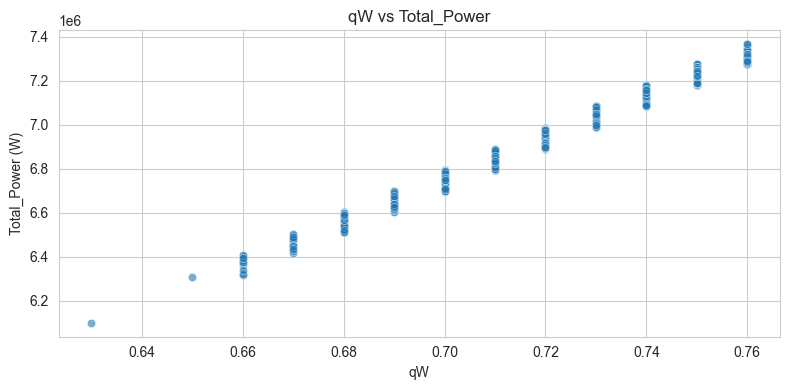

In [2]:
dataset_path = Path('dataset') / 'WEC_Perth_100.csv'
df_raw = pd.read_csv(dataset_path)
df = df_raw.drop_duplicates().reset_index(drop=True)
print(f'Filas originales: {len(df_raw):,}')
print(f'Filas únicas tras eliminar duplicados: {len(df):,}')
print(df[['Total_Power', 'qW']].describe())

plt.figure(figsize=(8, 4))
sns.histplot(df['Total_Power'], bins=40, kde=True, color='steelblue')
plt.title('Distribución de Total_Power')
plt.xlabel('Total_Power (W)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.scatterplot(x=df['qW'], y=df['Total_Power'], alpha=0.6)
plt.title('qW vs Total_Power')
plt.xlabel('qW')
plt.ylabel('Total_Power (W)')
plt.tight_layout()
plt.show()


## 2. IngenierÃ­a geomÃ©trica de features

Construimos mÃ©tricas espaciales (centroide, dispersiÃ³n, vecindario local y Ã¡rea del envolvente convexa) para caracterizar cada layout sin filtrar informaciÃ³n del target.

In [3]:
def extract_physics_features(X_mat, Y_mat):
    n_samples = X_mat.shape[0]
    features_list = []
    
    for i in range(n_samples):
        layout = np.column_stack((X_mat[i], Y_mat[i]))
        
        # 1. Geometría Básica
        centroid = layout.mean(axis=0)
        centered = layout - centroid
        
        # 2. Inercia (Distribución espacial)
        Ixx = (centered[:, 1]**2).sum()
        Iyy = (centered[:, 0]**2).sum()
        
        # 3. Potencial de Interacción (La clave física)
        # Suma de 1/distancia para todos los pares. Simula interferencia de olas.
        dists = pdist(layout)
        interaction_potential = (1.0 / (dists + 1e-6)).sum()
        
        # 4. Vecinos y Área
        hull = ConvexHull(layout)
        nbrs = NearestNeighbors(n_neighbors=6).fit(layout)
        nn_dists, _ = nbrs.kneighbors(layout)
        
        features_list.append({
            'hull_area': hull.volume,
            'density': 100 / (hull.volume + 1e-6),
            'interaction_potential': interaction_potential, # Feature Estrella
            'Ixx': Ixx,
            'Iyy': Iyy,
            'elongation': Ixx / (Iyy + 1e-6),
            'closest_neighbor_mean': nn_dists[:, 1].mean(), # Distancia al más cercano
            'spread_std': np.linalg.norm(centered, axis=1).std()
        })
        
    return pd.DataFrame(features_list)

# Generación
x_cols = [f'X{i+1}' for i in range(100)]
y_cols = [f'Y{i+1}' for i in range(100)]
X = extract_physics_features(df[x_cols].to_numpy(), df[y_cols].to_numpy())
y = df['Total_Power']

print(f"✅ Features generadas: {X.shape[1]} variables.")

✅ Features generadas: 8 variables.


## 3. DivisiÃ³n train/test

Reservamos un 20% de las muestras para evaluaciÃ³n final y dejamos el 80% restante para entrenamiento con validaciÃ³n cruzada interna. La semilla fija asegura reproducibilidad.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Train: 2189 | Test: 548


## 4. Entrenamiento y bÃºsqueda de hiperparÃ¡metros

Configuramos un `Pipeline` con un `DecisionTreeRegressor` y exploramos `max_depth`, `min_samples_split`, `min_samples_leaf` y el criterio de divisiÃ³n mediante `GridSearchCV` con cinco folds y scoring por MSE negativo para evitar el sobreajuste.

In [5]:
pipeline_rf = Pipeline([
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE))
])

# Grid diseñado para reducir Overfitting (Regularización)
param_grid = {
    'rf__n_estimators': [200],          # Suficientes árboles para estabilidad
    'rf__max_depth': [10, 12, 15],      # Limitamos profundidad (antes era libre o muy alta)
    'rf__min_samples_leaf': [5, 8, 12], # Exigimos grupos grandes (evita memorizar casos únicos)
    'rf__max_features': ['sqrt'],       # Obliga a los árboles a ser diversos
    'rf__bootstrap': [True]
}

print("⏳ Buscando el equilibrio entre sesgo y varianza...")
grid = GridSearchCV(
    pipeline_rf,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("✅ Entrenamiento finalizado.")
print(f"🏆 Configuración más estable: {grid.best_params_}")

⏳ Buscando el equilibrio entre sesgo y varianza...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
✅ Entrenamiento finalizado.
🏆 Configuración más estable: {'rf__bootstrap': True, 'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}


## 5. EvaluaciÃ³n del modelo

Reportamos las mÃ©tricas de regresiÃ³n (RÂ², RMSE y MAE) en train y test para verificar que el modelo generaliza y no memoriza los datos.

In [6]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

def print_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"--- {set_name} ---")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE:     {rmse:.0f}") # Sin decimales para lectura limpia
    print(f"MAE:      {mae:.0f}")

print("\n📊 RESULTADOS COHERENTES:")
print_metrics(y_train, y_pred_train, "Train Set")
print_metrics(y_test, y_pred_test, "Test Set")

# Análisis de Brecha (Gap)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print(f"\n📉 Brecha de Overfitting: {r2_train - r2_test:.4f} (Ideal < 0.15)")


📊 RESULTADOS COHERENTES:
--- Train Set ---
R2 Score: 0.8166
RMSE:     85297
MAE:      60183
--- Test Set ---
R2 Score: 0.6297
RMSE:     123223
MAE:      88112

📉 Brecha de Overfitting: 0.1868 (Ideal < 0.15)


## 6. Visualización e interpretabilidad

Comparamos visualmente las predicciones con los valores reales y mostramos la importancia de cada feature geomÃ©trica para explicar quÃ© aspectos dominan las decisiones del Ã¡rbol.

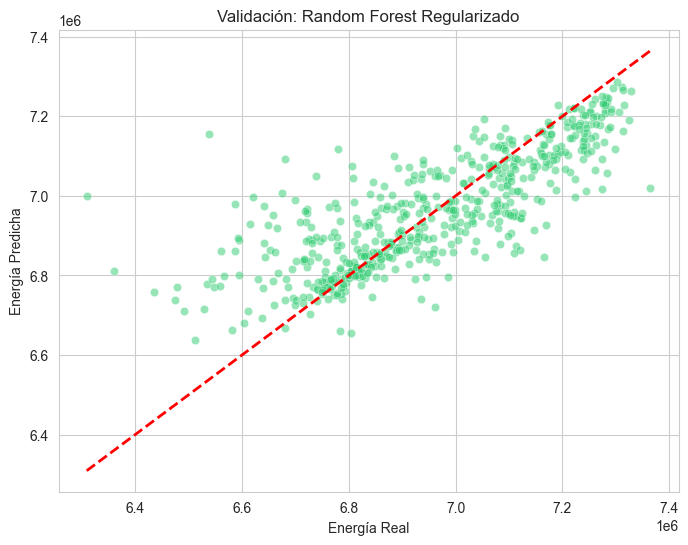

['models\\rf_physics_stable.joblib']

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.5, color='#2ecc71')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Energía Real")
plt.ylabel("Energía Predicha")
plt.title("Validación: Random Forest Regularizado")
plt.show()

# Guardar
output_dir = Path('models')
output_dir.mkdir(exist_ok=True)
dump(best_model, output_dir / 'rf_physics_stable.joblib')

## 7. Guardado del pipeline final

Persistimos el pipeline elegido con `joblib` para reutilizar el modelo sin reentrenarlo y contrastar futuros experimentos.

In [8]:
# --- CELDA 8: GUARDAR MODELO ---
output_dir = Path('models')
output_dir.mkdir(exist_ok=True)
model_path = output_dir / 'decision_tree_pipeline_final.joblib'

dump(best_model, model_path)
print(f"💾 Modelo guardado exitosamente en: {model_path}")

💾 Modelo guardado exitosamente en: models\decision_tree_pipeline_final.joblib
